In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# Extreme/Growing degree day calculation

In [2]:
# Degree day function
def above_threshold_each(mins, maxs, threshold):
    """Use a sinusoidal approximation to estimate the number of Growing
    Degree-Days above a given threshold, using daily minimum and maximum
    temperatures.
    mins and maxs are numpy arrays; threshold is in the same units."""

    """
    Code from James Rising (https://github.com/jrising/research-common/blob/master/python/gdd.py)
    """

    # Determine crossing points, as a fraction of the day
    plus_over_2 = (mins + maxs)/2
    minus_over_2 = (maxs - mins)/2
    two_pi = 2*np.pi
    # d0s is the times of crossing above; d1s is when cross below
    d0s = np.arcsin((threshold - plus_over_2) / minus_over_2) / two_pi
    d1s = .5 - d0s

    # If always above or below threshold, set crossings accordingly
    aboves = mins >= threshold
    belows = maxs <= threshold

    d0s[aboves] = 0
    d1s[aboves] = 1
    d0s[belows] = 0
    d1s[belows] = 0

    # Calculate integral
    F1s = -minus_over_2 * np.cos(2*np.pi*d1s) / two_pi + plus_over_2 * d1s
    F0s = -minus_over_2 * np.cos(2*np.pi*d0s) / two_pi + plus_over_2 * d0s
    return F1s - F0s - threshold * (d1s - d0s)

# ufunc for dask
def edd_ufunc_annual(tasmin, tasmax, threshold):
    return xr.apply_ufunc(above_threshold_each,
                          tasmin, tasmax, threshold,
                          dask = 'allowed')

In [19]:
# Read Livneh obs (one year)
ds = xr.open_mfdataset('/data/rsriver/c/davidcl2/Livneh_obs/livneh_NAmerExt_15Oct2014.1950*.nc')

In [23]:
%%time
# Specify upper and lower bounds in degC
# GDD defined for lower < GDD < upper, EDD for EDD > upper
upper = 29.0
lower = 10.0

# Calculate daily EDD
EDD = edd_ufunc_annual(ds['Tmin'], ds['Tmax'], threshold = 29.0).compute()
    
# Calculate daily GDD
GDD = edd_ufunc_annual(ds['Tmin'], ds['Tmax'], threshold = 10.).compute()
GDD = GDD - EDD

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 29.8 s, sys: 11 s, total: 40.7 s
Wall time: 49.9 s


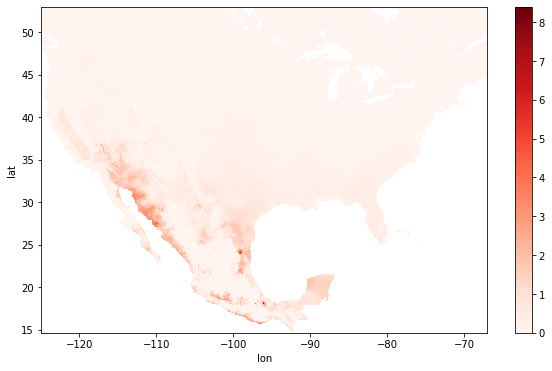

In [24]:
# Sample plot: annual average
fig, ax = plt.subplots(figsize=(10,6))

EDD.mean(dim='time').plot(cmap='Reds', ax=ax)

plt.show()

## Speed up with dask

### Set up cluster

In [3]:
from dask_jobqueue import SLURMCluster

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="16GB",
                       scheduler_options={'host': '172.22.179.3:7065'}) # Change the last 4 numbers here to something else between 7000-8000

In [5]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /data/keeling/a/davidcl2/dask//dask-worker-%J.err
#SBATCH -o /data/keeling/a/davidcl2/dask//dask-worker-%J.out
#SBATCH -p seseml
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=15G
#SBATCH -t 00:30:00

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/bin/python -m distributed.cli.dask_worker tcp://172.22.179.3:7065 --nthreads 1 --memory-limit 14.90GiB --name dummy-name --nanny --death-timeout 60 --local-directory /data/keeling/a/davidcl2/tmp/ --protocol tcp://



In [6]:
cluster.scale(10)

In [7]:
from dask.distributed import Client

In [8]:
client = Client(cluster)

In [9]:
client

<Client: 'tcp://172.22.179.3:7065' processes=8 threads=8, memory=119.20 GiB>

The [dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) above is a very useful way to monitor computations using dask. Make sure you have the `jobqueue.yaml` file in this repository copied into `$HOME/.config/dask/` on keeling and change `YOUR-USER-ID` where appropriate. 

### Calculate entire historical period

In [10]:
# Read Livneh obs (entire historical period) - need dask for this!
ds = xr.open_mfdataset('/data/rsriver/c/davidcl2/Livneh_obs/livneh_NAmerExt_15Oct2014.*.nc')

In [ ]:
%%time
# Specify upper and lower bounds in degC
# GDD defined for lower < GDD < upper, EDD for EDD > upper
upper = 29.0
lower = 10.0

# Calculate daily EDD
EDD = edd_ufunc_annual(ds['Tmin'], ds['Tmax'], threshold = 29.0).compute()
    
# Calculate daily GDD
GDD = edd_ufunc_annual(ds['Tmin'], ds['Tmax'], threshold = 10.).compute()
GDD = GDD - EDD